In [ ]:
# # Gaussian Kernel Regression (GKR) implementation
import tensorflow as tf
import numpy as np
import gpflow
from sklearn.model_selection import train_test_split
from sklearn.covariance import GraphicalLasso

FLOAT_TYPE = "float64"
tf.keras.backend.set_floatx(FLOAT_TYPE)
gpflow.config.set_default_float(FLOAT_TYPE)

class GKR_Fitter():
    def __init__(self, n_input, n_output, circular_period=None, fit_valid_split=0.3, learning_rate=0.1, n_epochs=100, gpr_params={}, cov_fit_batch_size=3000, kernel_params={}):
        """
        Gaussian Kernel Regression (GKR) Fitter class for fitting both mean and covariance. The whole idea is simple: 1. fit the mean using GP regression (by the GP_Fitter class), 2. fit the covariance using a kernel-based approach (by the Kernel_Cov class).

        Parameters:
            n_input (int): Number of input features/labels (e.g., x, y, speed, stimuli labels, or other behavioral variables). If the label is time, this is equivalent to performing temporal smoothing of neural trajectories, with additional noise covariance at different time points.
            n_output (int): Number of output features (i.e., number of neurons)
            circular_period (float or list, optional): Period for the input features. Later in the fit method, input features x should be constructed as a 2D matrix with shape (n_samples, n_input). This circular period variable describes the period of each of the input features. There are multiple ways to set this:
                1. None: None of the input features are circular
                2. scalar: All of the input features are circular with the same period
                3. list: Each of the input features is circular with the corresponding period. The length of the list should be the same as n_input. List can be a mixture of None and scalars.
            fit_valid_split (float): Fraction of validation data when fitting the covariance. See manuscript for more details. (default: 0.3)
            learning_rate (float): Learning rate for Adam optimizer (default: 0.1)
            n_epochs (int): Number of training epochs (default: 100)
            gpr_params (dict): Parameters for GP_Fitter for mean estimation. Here are a few frequently used parameters:
                - n_inducing (int or None): number of inducing points. The fewer inducing variable, the faster the fitting. If None, n_inducing = number of sample points.
                - seperate_kernel (bool): Whether to use different kernel for each output feature. If True, each output feature will have its own kernel. If False, all output features will share the same kernel. Default is False which is faster.

                referring to the GP_Fitter class for more details.

            cov_fit_batch_size (int): We split the data into batches for covariance fitting. This is the batch size. (default: 3000)

            kernel_params (dict): Parameters for kernel covariance estimation. See the Kernel_Cov class for more details.
        """
        self.n_input = n_input # number of input features, or labels, e.g. (x, y, speed) in the manuscript
        self.n_output = n_output # number of output features, e.g. the number of neurons
        self.circular_period = circular_period # circular period for circular variables
        self.fit_valid_split = fit_valid_split
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

        self.gpr_mean = GP_Fitter(circular_period=self.circular_period, **gpr_params)
        self.kc = Kernel_Cov(self.n_input, self.n_output, circular_period, **kernel_params)
        self.cov_fit_batch_size = cov_fit_batch_size

    def fit(self, r, x, fit_cov=True):
        """
        Fit the GKR model to the data by first fitting the mean using GP regression,
        then fitting the covariance using a kernel-based approach.

        Parameters:
            r (array-like): Response variables/targets, shape (n_samples, n_output)
            x (array-like): Input features, shape (n_samples, n_input)
            fit_cov (bool): Whether to fit the covariance (default: True)

        Returns:
            list: List of training losses for each epoch
        """
        self.r = np.array(r, dtype=FLOAT_TYPE)
        self.x = np.array(x, dtype=FLOAT_TYPE)

        ##########
        # Fit the mean
        ##########
        self.gpr_mean.fit(self.r, self.x)
        r_pred, _ = self.gpr_mean.predict(self.x)

        ##########
        # Fit the covariance
        ##########
        if not fit_cov:
            return

        r_ = self.r - r_pred # shift the mean to 0

        optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)
        dataset = tf.data.Dataset.from_tensor_slices((r_, self.x)).batch(self.cov_fit_batch_size)

        print('Fitting the covariance...')

        epoch_loss_list = []

        for ne in range(self.n_epochs):
            print(f'Epochs: {ne+1}/{self.n_epochs}')
            epoch_loss = 0  # Initialize a variable to accumulate loss for the epoch
            for i, (r_batch, x_batch) in enumerate(dataset):
                print(f'Batch: {i+1}/{ int( len(r_)/ self.cov_fit_batch_size ) }')

                r_train, r_valid, x_train, x_valid = train_test_split(r_batch.numpy(), x_batch.numpy(), test_size=self.fit_valid_split)
                with tf.GradientTape() as tape:
                    self.kc.fit(r_train, x_train)
                    cov_pred = self.kc.predict_cov(x_valid)
                    loss = - gaussian_log_likelihood(r_valid, cov_pred)
                gradients = tape.gradient(loss, self.kc.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.kc.trainable_variables))
                epoch_loss += loss.numpy()

            epoch_loss_list.append(epoch_loss)
            print(f'Training epoch loss: {epoch_loss}')

        self.kc.fit(r_, self.x)
        return epoch_loss_list

    def predict(self, query, return_cov=True, with_GLASSO=None):
        """
        Predict mean and covariance for new input points.

        Parameters:
            query (array-like): Query points to predict, shape (n_queries, n_input)
            return_cov (bool): Whether to return covariance prediction (default: True)
            with_GLASSO (float, optional): If not None, applies Graphical LASSO with this alpha value. In practice, we found with_GLASSO is usually unnecessary.

        Returns:
            predicted_mean: shape (n_queries, n_output). Which is also called "manifold"
            predicted_covariance: shape (n_queries, n_output, n_output) if return_cov=True, else None
        """
        query_ = query.astype(FLOAT_TYPE)
        r_pred, _ = self.gpr_mean.predict(query_)
        if return_cov:
            cov_pred = self.kc.predict_cov(query_).numpy()
            if with_GLASSO is not None:
                cov_glasso_matrices = np.zeros_like(cov_pred)
                n_sample = cov_pred.shape[0]

                # Apply Graphical LASSO to each covariance matrix
                for i in range(n_sample):
                    glasso = GraphicalLasso(alpha=with_GLASSO, assume_centered=True)
                    glasso.fit(cov_pred[i])

                    cov_glasso_matrices[i] = glasso.covariance_
                cov_pred = cov_glasso_matrices
        else:
            cov_pred = None

        return r_pred, cov_pred

class Kernel_Cov(tf.Module):
    """
    Kernel-based covariance estimation module.

    Estimates covariance matrices using a kernel-based approach with learnable precision matrix.
    Handles circular variables through appropriate distance calculations.
    """

    def __init__(self, n_input, n_output, circular_period=None, diag_factor=1e-6):
        """
        Initialize the kernel covariance estimator.

        Parameters:
            n_input (int): Number of input features
            n_output (int): Number of output features
            circular_period (float or list, optional): Period for circular variables
            diag_factor (float): Small constant added to diagonal for numerical stability
        """
        self.circular_period = circular_period
        self.n_input = n_input
        self.n_output = n_output
        self.diag_factor = diag_factor
        initial_L = tf.linalg.band_part(tf.random.normal((self.n_input, self.n_input), dtype=FLOAT_TYPE), -1, 0)
        self.kernel_prec_L = tf.Variable(initial_L, dtype=FLOAT_TYPE)

    def fit(self, r, x):
        self.r = np.array(r, dtype=FLOAT_TYPE)
        self.x = np.array(x, dtype=FLOAT_TYPE)

    def predict_cov(self, query, pred_batch_size=1000):
        """
        Predict covariance matrices for query points.

        Parameters:
            query (array-like): Query points, shape (n_queries, n_input)
            pred_batch_size (int): Batch size for prediction to manage memory usage

        Returns:
            tensor: Predicted covariance matrices, shape (n_queries, n_output, n_output)
        """
        query = np.array(query, dtype=FLOAT_TYPE)
        L = tf.linalg.band_part(self.kernel_prec_L, -1, 0)
        kernel_prec_mat = tf.matmul(L, tf.transpose(L)) # (n_input, n_input)
        n_sample = self.x.shape[0]
        n_query = query.shape[0]

        cov_pred = tf.zeros((n_query, self.n_output, self.n_output), dtype=FLOAT_TYPE)
        kernel_sum_total = tf.zeros(n_query, dtype=FLOAT_TYPE)
        for start in range(0, n_sample, pred_batch_size):
            end = min(start + pred_batch_size, n_sample)

            diff = self.x[start:end, None, :] - query[None, ...] # (pred_batch_size, n_query, n_input)
            diff = self._circular_diff(diff, self.circular_period)

            diff_prec = tf.einsum('ijk,kl,ijl->ij', diff, kernel_prec_mat, diff) # (pred_batch_size, n_query)
            kernel_matrix = tf.exp(-diff_prec)
            kernel_sum = tf.reduce_sum(kernel_matrix, axis=0)

            gram = self._compute_gram(self.r[start:end], 0) # (pred_batch_size, n_output, n_output)

            cov_pred += tf.einsum('qi,qjk->ijk', kernel_matrix, gram)
            kernel_sum_total += kernel_sum

        cov_pred = cov_pred / kernel_sum_total[:, None, None]
        cov_pred = cov_pred + tf.eye(self.n_output, dtype=FLOAT_TYPE) * self.diag_factor
        return cov_pred

    @staticmethod
    def _compute_gram(response_train, response_pred):
        diff = response_train - response_pred
        gram = tf.einsum('ij,ik->ijk', diff, diff)
        return gram

    @staticmethod
    def _circular_diff(diff, periods):
        """
        For cases where the label is a circular variable
        Parameters:
        diff (Tensor [n_sample, n_query, n_input]):
        periods: The periods for circularity, which can be None, a scalar, or a list.
          - If None, no modification is made.
          - If a scalar, the same period is applied to all dimensions.
          - If a list, each dimension is modified according to the corresponding period in the list (None for no modification).

        Returns:
        Tensor: The modified differences.
        """
        if periods is None: return diff

        if np.isscalar(periods):
            # Apply the same period to all dimensions
            return tf.math.square(tf.math.sin(np.pi * diff / periods))

        # Apply different periods for each dimension
        for i, period in enumerate(periods):
            if period is not None:
                diff[..., i] = tf.math.square(tf.math.sin(np.pi * diff[..., i] / period))
        return diff

@tf.function
def gaussian_log_likelihood(r, cov_pred, diag_factor=1e-5):
    diag = tf.eye(cov_pred.shape[-1], dtype=FLOAT_TYPE) * diag_factor
    chol = tf.linalg.cholesky(cov_pred + diag)
    log_det = 2 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol)), axis=-1)

    sol = tf.linalg.triangular_solve(chol, tf.expand_dims(r, -1), lower=True)
    quadratic_term = tf.reduce_sum(tf.square(sol), axis=[1, 2])

    log_likelihood = -0.5 * tf.reduce_mean(log_det + quadratic_term)
    return log_likelihood


class GP_Fitter():
    def __init__(self, kernel=None, circular_period=None, standardize=True, n_inducing=None, seperate_kernel=False):
        '''
        kernel (): The kernel to use for the GP model. Can be None to use the default kernel settings.
        circular_period (None, scalar, or list): Specifies the periodicity for the kernel.
         - If None, a non-periodic kernel is created.
         - If a scalar, all dimensions use the same periodicity.
         - If a list, each dimension gets its specified periodicity; None for non-periodic.
         standardize (bool): Whether to standardize the input data.
         n_inducing (int or None): number of inducing points. The fewer inducing variable, the faster the fitting. If None, do not use inducing variables, which is slowest because it uses full GP.
         seperate_kernel (bool): Whether to use different kernel for each output feature. If True, each output feature will have its own kernel. If False, all output features will share the same kernel. Default is False which is faster.

        '''
        self.n_inducing = n_inducing # if None --> GPR, else SGPR
        self.circular_period = circular_period
        self.kernel = kernel

        self.standardize = standardize
        self.standardize_feamap_mean = 0
        self.standardize_feamap_std = 1
        self.seperate_kernel = seperate_kernel


    def fit(self, feamap, label):
        # standardize the data
        if self.standardize:
            self.standardize_feamap_mean = feamap.mean(axis=0)
            self.standardize_feamap_std = feamap.std(axis=0)
            feamap_cp = (feamap - self.standardize_feamap_mean) / self.standardize_feamap_std
        else:
            feamap_cp = feamap.copy()

        if self.seperate_kernel:
            if self.kernel is None: self.kernel = [create_kernel(circular_period=self.circular_period, input_dim=label.shape[1]) for _ in range(feamap_cp.shape[1])]
            self.model = MultiKernelGPModel(self.kernel, n_inducing=self.n_inducing)
        else:
            if self.kernel is None: self.kernel = create_kernel(circular_period=self.circular_period, input_dim=label.shape[1])
            self.model = SharedKernelGPModel(self.kernel, n_inducing=self.n_inducing)

        self.model.fit(label, feamap_cp)

    def predict(self, query_mesh=None, x_bound=[-0.8, 0.8], y_bound=[-0.8, 0.8], n_spatial_bin=50):
        '''
        input:
            query_mesh: 2d array. The position of each spatial bin.
            x_bound, y_bound: the bound of the position. If None, use the min and max of x, y
            n_spatial_bin: number of spatial bins
        output:
            pred: 2d array. The predicted firing rate at each spatial bin
            query_mesh: 2d array. The position of each spatial bin
        '''
        if query_mesh is None:
            return NotImplementedError("Please provide query_mesh for prediction.")

        pred, _ = self.model.predict_f(query_mesh)

        # unstandardize the data
        if self.standardize:
            pred = pred * self.standardize_feamap_std + self.standardize_feamap_mean

        return pred, query_mesh

class SharedKernelGPModel:
    def __init__(self, kernel, n_inducing=None):
        self.kernel = kernel
        self.n_inducing = n_inducing
        self.model = None

    def fit(self, label, feamap_cp):

        if self.n_inducing is None:
            self.n_inducing = label.shape[0]

        self.n_inducing = min(self.n_inducing, label.shape[0])
        iv_idx = np.random.choice(np.arange(label.shape[0]), self.n_inducing, replace=False)
        iv = label[iv_idx]

        label_ = tf.cast(label, dtype=FLOAT_TYPE)
        feamap_cp_ = tf.cast(feamap_cp, dtype=FLOAT_TYPE)
        iv_ = tf.cast(iv, dtype=FLOAT_TYPE)
        self.model = gpflow.models.SGPR(
            (label_, feamap_cp_),
            self.kernel,
            inducing_variable=iv_,
        )

        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.model.training_loss, self.model.trainable_variables, method="l-bfgs-b")

    def predict_f(self, Xnew):
        Xnew_ = tf.cast(Xnew, dtype=FLOAT_TYPE)
        pred, var = self.model.predict_f(Xnew_)
        return pred.numpy(), var.numpy()

class MultiKernelGPModel:
    def __init__(self, kernel_list, n_inducing=None):
        self.kernel_list = kernel_list
        self.n_inducing = n_inducing
        self.models = []

    def fit(self, label, feamap_cp):
        for i, kernel in enumerate(self.kernel_list):
            model = SharedKernelGPModel(kernel, n_inducing=self.n_inducing)
            model.fit(label, feamap_cp[:, [i]])
            self.models.append(model)

    def predict_f(self, Xnew):
        means = []
        variances = []
        for model in self.models:
            mean, var = model.predict_f(Xnew)
            means.append(mean)
            variances.append(var)

        mean_concat = np.concatenate(means, axis=1)
        variance_concat = np.concatenate(variances, axis=1)

        return mean_concat, variance_concat


def create_kernel(circular_period=None, input_dim=1):
    """
    Create a GPflow kernel based on the provided circular_period specification.

    Parameters:
    circular_period (None, scalar, or list): Specifies the periodicity for the kernel.
        - If None, a non-periodic kernel is created.
        - If a scalar, all dimensions use the same periodicity.
        - If a list, each dimension gets its specified periodicity; None for non-periodic.

    Returns:
    gpflow.kernels.Kernel: The constructed GPflow kernel.
    """
    var = [1] * input_dim
    lengthscales = [1] * input_dim
    var_white = [1] * input_dim
    var_const = [1] * input_dim
    # Case 1: No periodicity specified, create a standard kernel
    if circular_period is None:
        return gpflow.kernels.SquaredExponential(lengthscales=lengthscales) + gpflow.kernels.White() + gpflow.kernels.Constant()

    # Case 2: Single scalar provided, apply the same periodicity to all dimensions
    if np.isscalar(circular_period):
        return gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(lengthscales=lengthscales), period=circular_period) + gpflow.kernels.White() + gpflow.kernels.Constant()

    # Case 3: A list of periods is provided, create individual kernels for each dimension.
    if isinstance(circular_period, list):
        kernels = []
        for i, period in enumerate(circular_period):
            # For each dimension, create a periodic kernel if period is specified, otherwise a standard kernel
            if period is None:
                kernels.append(gpflow.kernels.SquaredExponential(active_dims=[i]))
            else:
                print(f"Period: {i, period}")
                base_kernel = gpflow.kernels.SquaredExponential(active_dims=[i])
                kernels.append(
                    gpflow.kernels.Periodic(base_kernel, period=period)
                               )
        # Combine all the kernels together
        combined_kernel = gpflow.kernels.Product(kernels) + gpflow.kernels.White() + gpflow.kernels.Constant()

        return combined_kernel

    # Raise an error if the input doesn't match the expected format
    raise ValueError("Invalid input for circular_period")

e:\ProgramData\anaconda3\envs\tf210\lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
# # Import necessary libraries for data generation and visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Plot covariance ellipses
def plot_cov_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    # Compute eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Get the angle of rotation (from largest eigenvector)
    theta = np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0])

    # Width and height of ellipse (based on eigenvalues)
    width, height = 2 * n_std * np.sqrt(eigenvals)

    # Create the ellipse
    ellip = Ellipse(xy=mean, width=width, height=height,
                    angle=np.degrees(theta), **kwargs)
    ax.add_patch(ellip)

In [ ]:
def generate_circular_dataset(n_data, radius=1.0, noise_factor=0.1):
    # Generate angles for circle (between 0 and 2*pi)
    angles = np.linspace(0, 2 * np.pi, n_data)

    # Generate circle coordinates
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)

    # Stack the x, y coordinates to form the response (n_data, 2)
    response = np.stack((x, y), axis=1)

    # Add noise to the response
    noise = np.random.normal(scale=noise_factor, size=response.shape)
    response_noisy = response + noise

    # Generate scalar labels
    labels = angles.reshape(-1, 1)  # Labels could be scalar, here using angle as label

    return response_noisy, labels

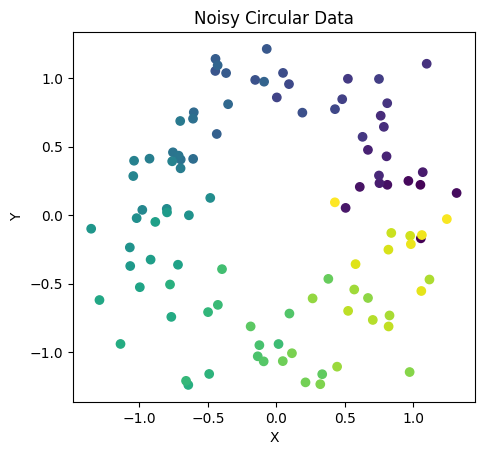

In [ ]:
# Example usage
n_data = 100
response_noisy, labels = generate_circular_dataset(n_data, radius=1.0, noise_factor=0.2) # response_noisy: (n_sample, n_neuron = 2); labels: (n_sample, n_label = 1)

# Plot the raw noisy circle data
plt.scatter(response_noisy[:, 0], response_noisy[:, 1], c=labels.ravel(), cmap='viridis')
plt.title("Noisy Circular Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
labels.shape[1]

1

In [ ]:
response_noisy.shape[1]

2

In [ ]:
response_noisy.shape

(100, 2)

In [ ]:
# If you want to apply GKR in your dataset, you need to
# 1. Prepare a label matrix of shape (n_sample, n_labels) and a neural response matrix of shape (n_sample, n_neuron).
# 2. Specify the periodicity of each label variable. If a variable is not periodic, set circular_period = None.
# 3. Use GKR shown as below.

gkr = GKR_Fitter(n_input=labels.shape[1], n_output=response_noisy.shape[1], circular_period=2*np.pi, gpr_params={'n_inducing': 10}, n_epochs=5) # n_inducing representing the number of inducing variable used to approximate the manifold.
# The smaller the faster. Maximum is the number of sample points, i.e. response_noisy.shape[0]. Circular_period is the period of label, set to None if the label variable is a non-circular variable.
_ = gkr.fit(response_noisy, labels, fit_cov=True)

Fitting the covariance...
Epochs: 1/5
Batch: 1/0
Training epoch loss: -2.136366042872129
Epochs: 2/5
Batch: 1/0
Training epoch loss: -2.250543945370443
Epochs: 3/5
Batch: 1/0
Training epoch loss: -2.2558837319491443
Epochs: 4/5
Batch: 1/0
Training epoch loss: -2.1428066813116415
Epochs: 5/5
Batch: 1/0
Training epoch loss: -2.3116988743360127


In [ ]:
# Draw the fitted manifold
label_pred = np.linspace(0, 2 * np.pi, 50).reshape(-1, 1) # Get a mesh points
response_pred, response_cov = gkr.predict(label_pred) # Get the manifold values of the mesh points (response_pred) along with their corresponding cov (response_cov)

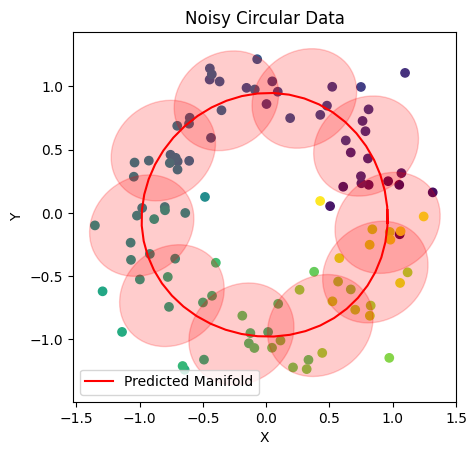

In [ ]:
# Plot the raw noisy circle data
plt.scatter(response_noisy[:, 0], response_noisy[:, 1], c=labels.ravel(), cmap='viridis')
plt.title("Noisy Circular Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')

# Plot the fitted manifold
plt.plot(response_pred[:, 0], response_pred[:, 1], 'r-', label='Predicted Manifold')

# Plot ellipses for every nth point to avoid overcrowding
n_skip = 5  # Adjust this value to show more or fewer ellipses
for i in range(0, len(response_pred), n_skip):
    plot_cov_ellipse(response_pred[i], response_cov[i],
                     plt.gca(), alpha=0.2, color='red')

plt.legend()